In [2]:
%load_ext autoreload
%autoreload 2

In [51]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr

In [3]:
p = Path("/Users/kaseyevans/OMSCS/CS7641/cs7641-hw4.2/output/smprob-26220000/blockdude")

In [5]:
for x in p.iterdir():
    print(x)
    break

/Users/kaseyevans/OMSCS/CS7641/cs7641-hw4.2/output/smprob-26220000/blockdude/pi_lrg_bd_01 gamma:0.9-00.episode.txt


In [43]:
frames = []

for x in p.iterdir():
    
    if x.match("*episode*"):
        continue
   
    # run params from name
    s = x.name.split("_")
    algo = s[0]
    size = s[1]
    param_name = x.name.split()[1].split(":")[0]
    param_value = x.name.split()[1].split(":")[1].split("-")[0]
    trial = x.name.split()[1].split(":")[1].split("-")[1].split(".")[0]
    
    # metrics
    df = pd.read_csv(x)
    df["algo"] = algo
    df["size"] = size
    df["param_name"] = param_name
    df["param_value"] = param_value
    df["trial"] = trial
    
    # total reward and steps at convergence
    path = (
        "/Users/kaseyevans/OMSCS/CS7641/cs7641-hw4.2/output/smprob-26220000/blockdude/"
        f"{algo}_{size}_bd_01\ {param_name}:{param_value}-00.epsiode.txt"
    )
    f_episode = None
    for fp in p.iterdir():
        if all([fp.match(x) for x in [f"*{algo}*", f"*{size}*", f"*{param_name}*", f"*{param_value}*", f"*{trial}*" "episode.txt"]]):
            f_episode = fp
            break
    with open(f_episode, "r") as fh:
        lines = fh.readlines()
    for line in lines:
        if "Reward Sequence" in line:
            rewards = line.split()[2:]
            break
 
    rewards[0] = rewards[0][1:]
    rewards[-1] = rewards[-1][:-1]
    total_rewards = sum([float(x.split(",")[0]) for x in rewards])
    numSteps = len(rewards)

    df["totalRewardAtConvergence"] = total_rewards
    df["numStepsAtConvergence"] = numSteps

    frames.append(df)

df = pd.concat(frames, ignore_index=True)

In [44]:
df.sample(10)

,iter,delta,wallclock,algo,size,param_name,param_value,trial,totalRewardAtConvergence,numStepsAtConvergence,evals
180,6,0.022607,1824,pi,lrg,gamma,0.7,00,-1249.0,1249,5.0
241,52,0.592967,221,vi,lrg,gamma,0.99,00,-94.0,94,NaN
109,3,79.319697,223,pi,sm,gamma,0.99,00,-19.0,19,20.0
354,165,0.190462,223,vi,lrg,gamma,0.99,00,-94.0,94,NaN
248,59,0.552684,227,vi,lrg,gamma,0.99,00,-94.0,94,NaN
154,2,0.670698,159,pi,sm,gamma,0.8,00,-19.0,19,11.0
1525,538,0.004485,8,vi,sm,gamma,0.99,00,-19.0,19,NaN
1244,257,0.075552,8,vi,sm,gamma,0.99,00,-19.0,19,NaN
1038,51,0.598956,8,vi,sm,gamma,0.99,00,-19.0,19,NaN
1783,19,0.002325,1401,pi,lrg,gamma,0.8,00,-1249.0,1249,4.0


In [88]:
def make_q_learning_plots(df, algo, param_name, output_name=None):

    df = (df[(df["param_name"] == param_name) &
             (df["algo"] == algo)]
         ).rename({"param_value": param_name}, axis=1)
    df.sort_values(by=["size", param_name, "trial", "iter"], inplace=True)

    size_map = {"sm": 0, "lrg": 1}
    size_to_title_map = {"sm": "Small", "lrg": "Large"}
    metric_to_title_map = {"delta": "$\Delta$ maxV", "wallclock": "Cumulative Wallclock (s)", "evals": "Inner VI Evals"}

    if algo == "pi":
        fig, axs = plt.subplots(3, 2, figsize=(9, 6.5), tight_layout=True)
        metric_map = {"evals": 0, "delta": 1, "wallclock": 2}
    else:
        fig, axs = plt.subplots(2, 2, figsize=(9, 4.33), tight_layout=True)
        metric_map = {"delta": 0, "wallclock": 1}
    plt.rcParams['text.usetex'] = True

    rolled = []
    for (param,size,trial), data in df.groupby([param_name,"size","trial"]):
        for metric in ["evals", "delta", "wallclock"]:
            if metric != "wallclock":
                # data[metric] = data[metric].rolling(window=3, center=True).mean()
                pass
            else:
                data[metric] = np.cumsum(1e-6 * data[metric])
        data[param_name] = param
        data["size"] = size
        data["trial"] = trial
        rolled.append(data)
    rolled_df = pd.concat(rolled, ignore_index=True)

    agged = rolled_df.groupby(["iter", param_name, "size"], as_index=False).agg(
        {"evals": ["median", iqr], "delta": ["median", iqr], "wallclock": ["median", iqr]})
    for (size,param), data in agged.groupby(["size", param_name]):
        for metric in ["evals", "delta", "wallclock"] if algo == "pi" else ["delta", "wallclock"]:
            ax = axs[metric_map[metric]][size_map[size]]
            x = data["iter"]
            y = data[metric]["median"]
            # .rolling(window=5, center=True).mean()
            ax.plot(x, y, label=f"$\\{param_name}: {param}$")
            # ax.fill_between(x, y+d, y-d, alpha=0.1)
            ax.set_title(f"{metric_to_title_map.get(metric, metric)} - {size_to_title_map[size]}")
            ax.set_xlabel("Iteration")
            ax.legend()

    if output_name:
        plt.savefig(output_name, dpi=500)
    else:
        plt.savefig(f"figures/BlockDude_{algo}_{param_name}.png", dpi=500)

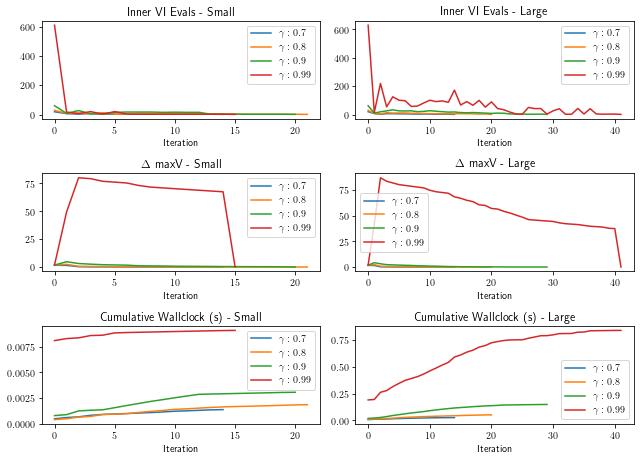

In [86]:
make_q_learning_plots(df, "pi", "gamma")

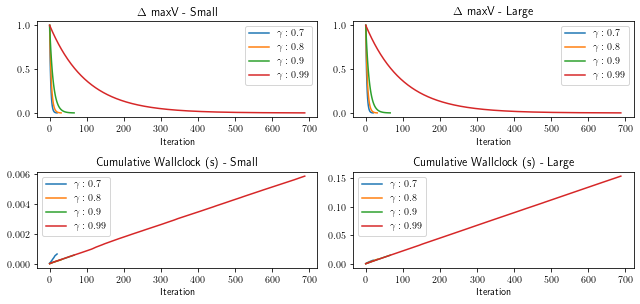

In [89]:
make_q_learning_plots(df, "vi", "gamma")

In [61]:
df_f = df[(df["size"] == "sm") & (df["algo"] == "pi") & (df["param_value"] == "0.99")]

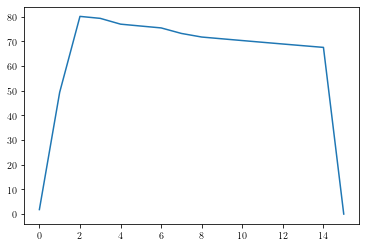

In [62]:
plt.plot(df_f["iter"], df_f["delta"])

In [90]:
df.head()

,iter,delta,wallclock,algo,size,param_name,param_value,trial,totalRewardAtConvergence,numStepsAtConvergence,evals
0,0,1.0000,13,vi,sm,gamma,0.8,00,-19.0,19,NaN
1,1,0.8000,11,vi,sm,gamma,0.8,00,-19.0,19,NaN
2,2,0.6400,10,vi,sm,gamma,0.8,00,-19.0,19,NaN
3,3,0.5120,10,vi,sm,gamma,0.8,00,-19.0,19,NaN
4,4,0.4096,9,vi,sm,gamma,0.8,00,-19.0,19,NaN


In [124]:
frames = []
for (size,algo,trial,param_value), data in df.groupby(by=["size", "algo", "trial", "param_value"]):
    data["wallclock_cumsum"] = np.cumsum(data["wallclock"])
    data["size"] = size
    data["algo"] = algo
    data["trial"] = trial
    data["param_value"] = param_value
    frames.append(data)

df_c = pd.concat(frames, ignore_index=True)

pd.set_option('display.float_format', '{:,.0f}'.format)


out = (df_c.merge(df_c.groupby(by=["size", "algo", "trial", "param_value"], as_index=False).agg({"iter": "max"}), on=["size", "algo", "iter", "param_value"]))

print(out[["algo", "size", "param_value", "iter", "wallclock_cumsum", "totalRewardAtConvergence", "numStepsAtConvergence"]]
.sort_values(by=["algo", "size", "param_value", "iter"]).to_latex()
)

\begin{tabular}{llllrrrr}
\toprule
{} & algo & size & param\_value &  iter &  wallclock\_cumsum &  totalRewardAtConvergence &  numStepsAtConvergence \\
\midrule
0  &   pi &  lrg &         0.7 &    14 &             26425 &                    -1,249 &                   1249 \\
1  &   pi &  lrg &         0.8 &    20 &             51741 &                    -1,249 &                   1249 \\
2  &   pi &  lrg &         0.9 &    29 &            148630 &                       -94 &                     94 \\
3  &   pi &  lrg &        0.99 &    41 &            838579 &                       -94 &                     94 \\
8  &   pi &   sm &         0.7 &    14 &              1368 &                       -19 &                     19 \\
9  &   pi &   sm &         0.8 &    21 &              1845 &                       -19 &                     19 \\
10 &   pi &   sm &         0.9 &    20 &              3052 &                       -19 &                     19 \\
11 &   pi &   sm &        0.99 &  

In [97]:
df["trial"].drop_duplicates()

0    00
Name: trial, dtype: object

In [125]:
df

,iter,delta,wallclock,algo,size,param_name,param_value,trial,totalRewardAtConvergence,numStepsAtConvergence,evals
0,0,1,13,vi,sm,gamma,0.8,00,-19,19,NaN
1,1,1,11,vi,sm,gamma,0.8,00,-19,19,NaN
2,2,1,10,vi,sm,gamma,0.8,00,-19,19,NaN
3,3,1,10,vi,sm,gamma,0.8,00,-19,19,NaN
4,4,0,9,vi,sm,gamma,0.8,00,-19,19,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1795,10,0,66,pi,sm,gamma,0.7,00,-19,19,3
1796,11,0,43,pi,sm,gamma,0.7,00,-19,19,2
1797,12,0,45,pi,sm,gamma,0.7,00,-19,19,2
1798,13,0,48,pi,sm,gamma,0.7,00,-19,19,2
